Title:

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RPostgres)
library(DBI)
library(readr)
library(dbplyr)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

Introduction:
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question


Preliminary exploratory data analysis:
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format

In [7]:

activity_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip" #ICS Machine Learning Training set archive      
temp <- tempfile() #Vector of character strings to be used for naming temporary files, saved to temp.
download.file(activity_url, temp) #Download Zip file from ICS archive, save into temp.
unzip(temp, "dataset_Facebook.csv") #Unzip File.

#Read dataset and factor Type Column
fb_data <- read_delim("dataset_Facebook.csv", ";") %>%                     
    mutate(Type = as.factor(Type))

#Delete Temporary Vector
unlink(temp)

#Tidying Data: Replace spaces in Column names with periods.
colnames(fb_data) <- make.names(colnames(fb_data))


fb_data <- fb_data %>%
#      filter(Total.Interactions > 500) %>%                                 #Use pages with >1000 interactions
select(Type, Post.Weekday, Total.Interactions) #Select the Type, Post.Weekday and Total.Interactions column as that is required for our Data Analysis
head(fb_data)

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Photo,4,100
Status,3,164
Photo,3,80
Photo,2,1777
Photo,2,393
Status,1,186


- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [8]:
fb_split <- initial_split(fb_data,
                          prop = 0.75,
                          strata = Type)  #splitting data
fb_train <- training(fb_split)   
fb_test <- testing(fb_split)

head(fb_train)
head(fb_test)

Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Photo,4,100
Photo,3,80
Photo,2,1777
Photo,2,393
Photo,1,279
Status,7,192


Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Status,3,164
Status,1,186
Photo,7,339
Photo,1,42
Photo,1,81
Link,7,18


- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

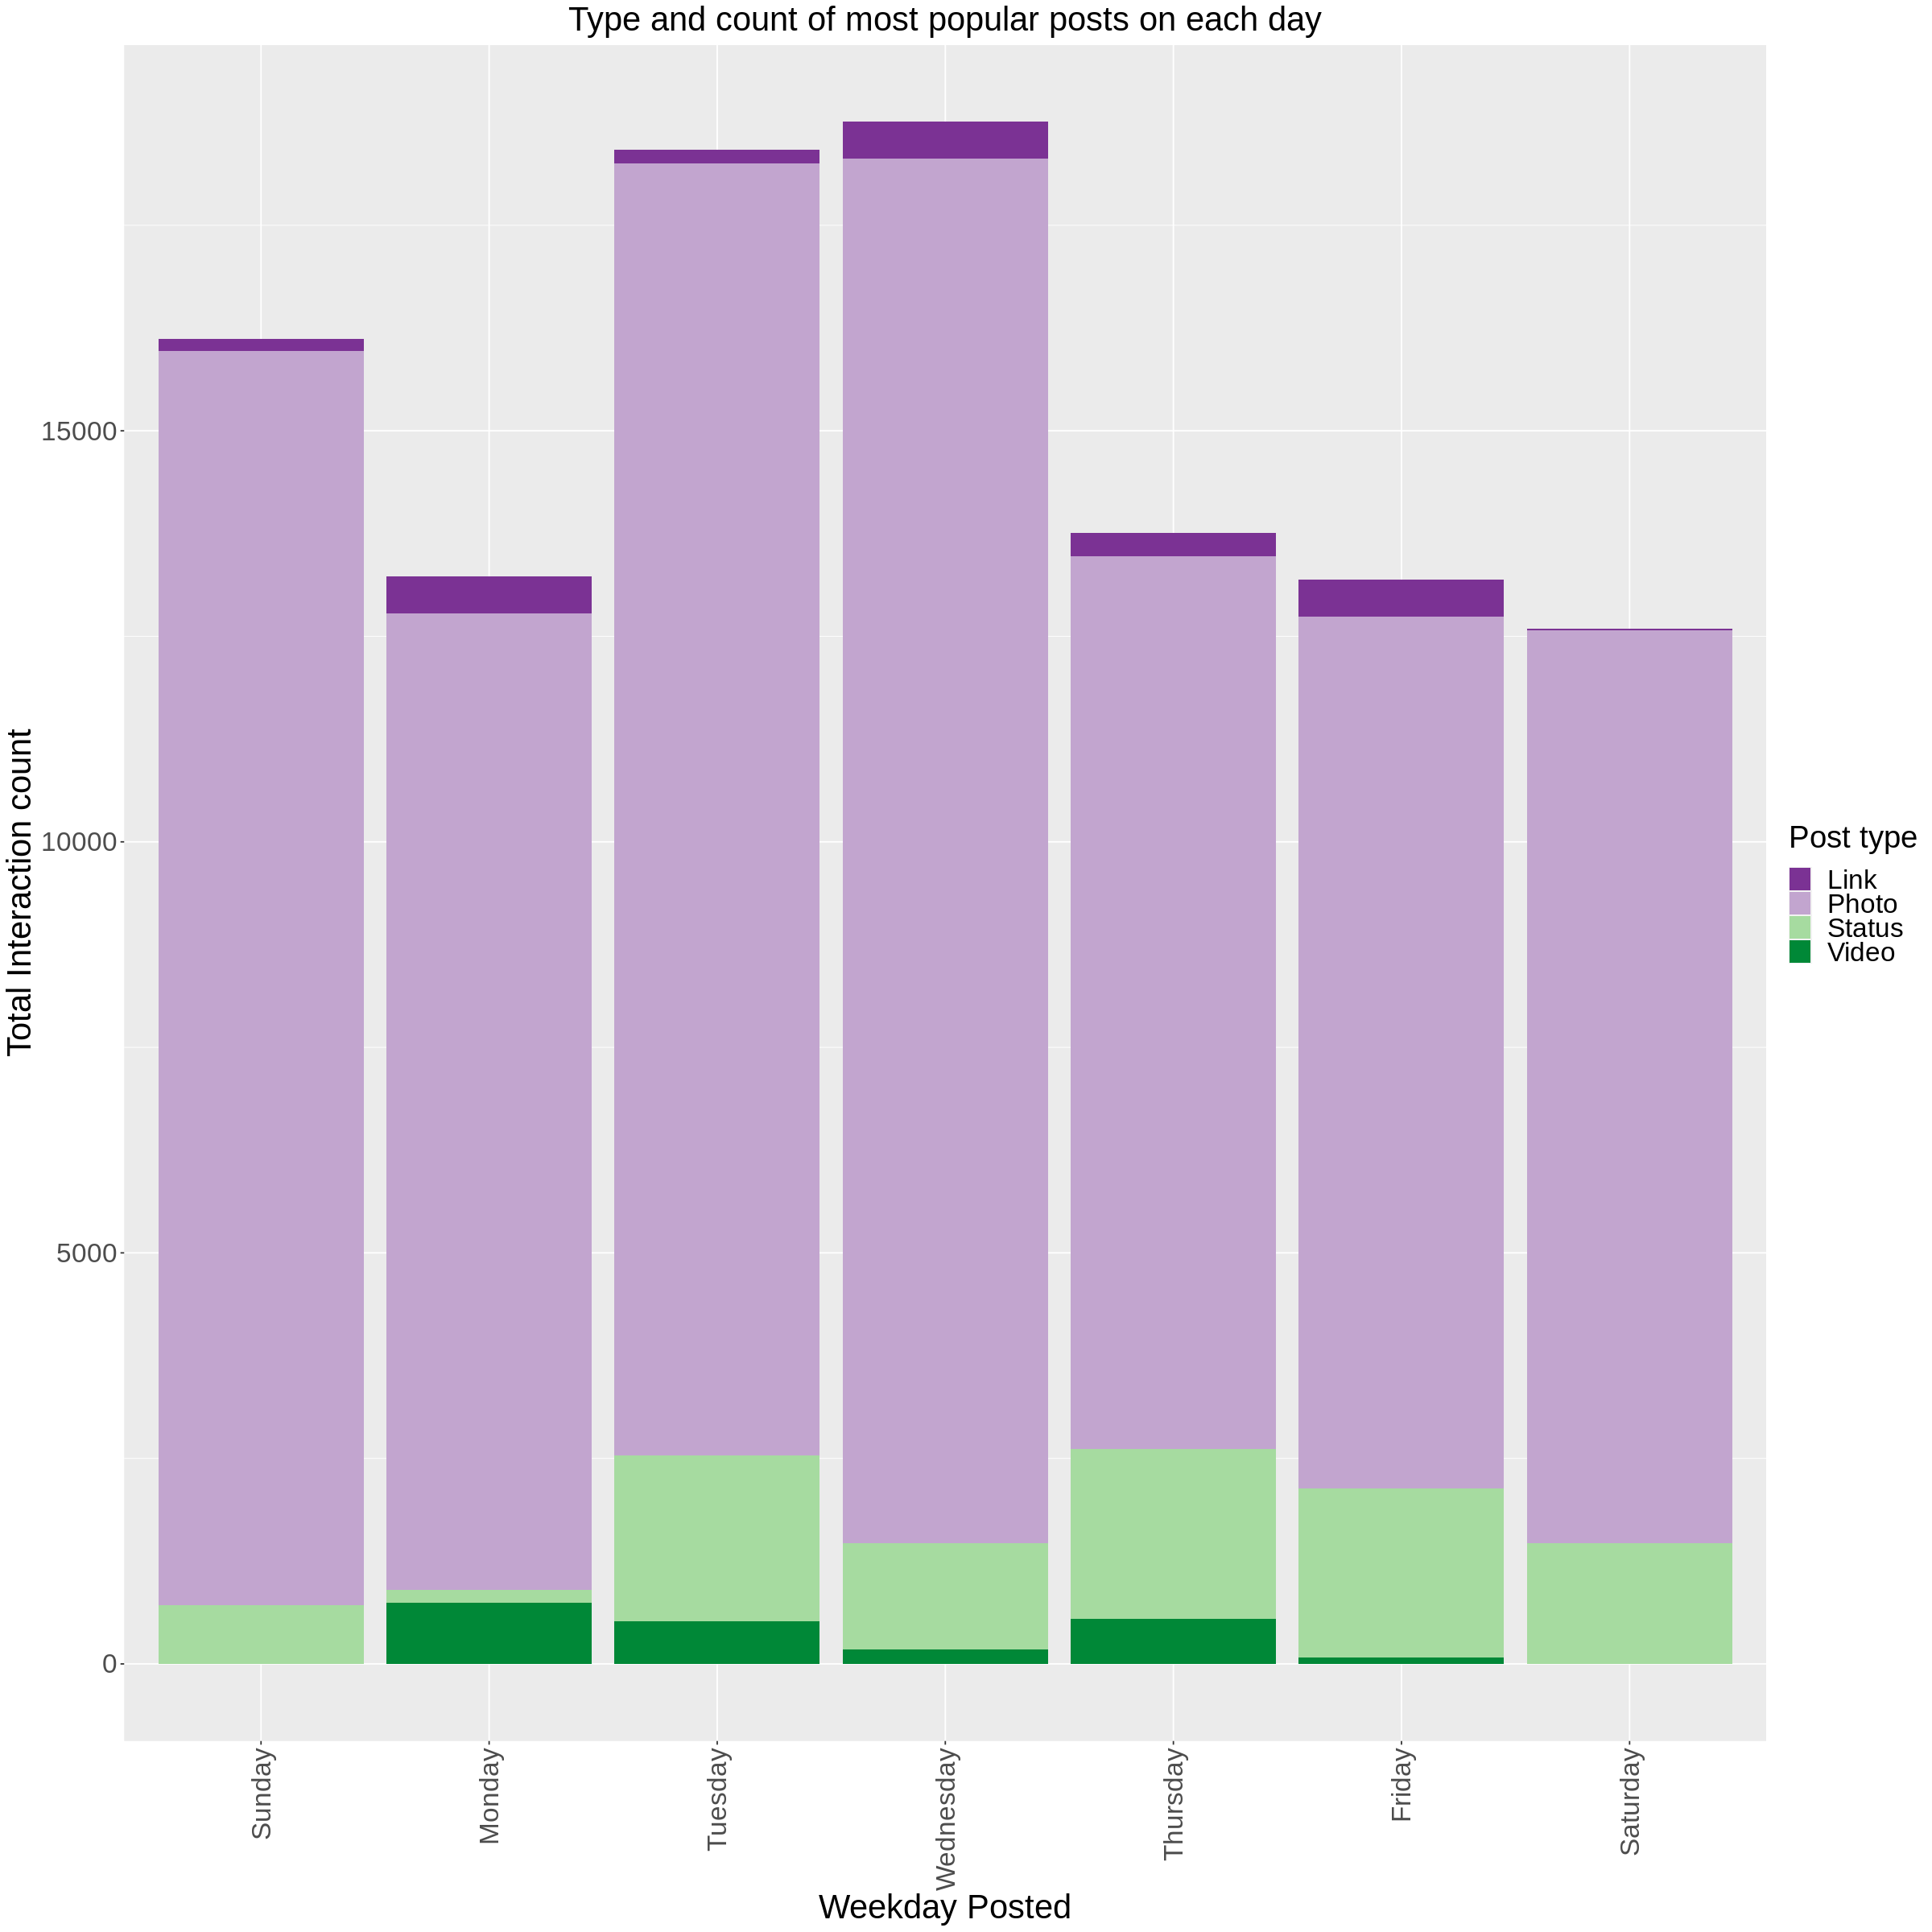

In [18]:
options(repr.plot.height = 20, repr.plot.width = 20)

most_interactions <- fb_data %>%                                      #plot of interactions and post type vs day
    arrange(desc(Post.Weekday)) %>%
    ggplot(aes(x = Post.Weekday, 
                 y = Total.Interactions,                     
                 fill = Type)) + 
    geom_bar(stat = "identity") +                                     #graph titles
    xlab("Weekday Posted") +
    ylab("Total Interaction count") +
    labs(fill = "Post type") +
    ggtitle("Type and count of most popular posts on each day") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25, hjust = 0.5),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
            scale_fill_brewer(palette = 'PRGn') +
        scale_x_discrete(limits=c("1", "2", "3", "4", "5", "6", "7"), labels=c("1" = "Sunday", "2" = "Monday", "3" = "Tuesday", "4" = "Wednesday", "5" = "Thursday", "6" = "Friday", "7" = "Saturday" ))


most_interactions

#### Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?